In [34]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import matplotlib.pyplot as plt

In [35]:
csv_file_path = '/home/lucas/UFOP/ple_2020/analise_midias_sociais/final-work/data/all_pp_posts_haddad_replaced_to_empty_removing_other_words.csv'
df_candidate = pd.read_csv(csv_file_path,encoding = 'utf-8')

In [36]:
# convertendo o tipo data que esta como string em objeto no formato data
df_candidate["created_time"] = pd.to_datetime(df_candidate['created_time'])

In [37]:
df_candidate.head(15)

,created_time,id,message_max_processed,m_m_p_replaced_to_empty,shares,status_type,full_picture,reactions_like,reactions_haha,reactions_wow,reactions_sad,reactions_angry,reactions_love,has_textual_message
0,2020-02-29 11:23:27+00:00,904277726319518_2878974912183113,bolsonavirus nada erroneo considerar bolsonaro...,bolsonavirus nada erroneo considerar acident...,818,shared_story,https://external-gru1-1.xx.fbcdn.net/safe_imag...,4996,209,19,40,58,636,True
1,2020-02-29 09:21:22+00:00,904277726319518_2878783568868914,bolsonavirus nada erroneo considerar bolsonaro...,bolsonavirus nada erroneo considerar raio ce...,477,shared_story,https://external-gru1-1.xx.fbcdn.net/safe_imag...,2602,84,14,26,19,130,True
2,2020-02-28 00:14:25+00:00,904277726319518_2875616525852285,cristiano zanin advogado lula fernando haddad ...,cristiano zanin advogado discutem novidade...,540,mobile_status_update,https://scontent-gru2-2.xx.fbcdn.net/v/t15.525...,3068,120,23,4,20,140,True
3,2020-02-26 12:12:56+00:00,904277726319518_2872245456189392,disney pao ano governo bolsonaro sabia falta d...,disney pao ano governo sabia falta dinheiro ...,1068,shared_story,https://external-gru1-1.xx.fbcdn.net/safe_imag...,3148,48,24,1306,616,8,True
4,2020-02-26 00:58:59+00:00,904277726319518_2871255852955019,bolsonaro tudo indica cometeu crime responsabi...,tudo indica cometeu crime responsabilidade p...,1369,mobile_status_update,None,21619,524,79,68,77,1923,True
5,2020-02-24 19:51:01+00:00,904277726319518_2868531243227480,impacto fundeb criamos qualidade educacao nord...,impacto fundeb criamos qualidade educacao nord...,3249,shared_story,https://external-gru1-1.xx.fbcdn.net/safe_imag...,10571,86,45,9,2,2635,True
6,2020-02-22 13:03:28+00:00,904277726319518_2863199017094036,cronica semana podemos descuidar dois problema...,cronica semana podemos descuidar dois problema...,528,shared_story,https://external-gru1-1.xx.fbcdn.net/safe_imag...,2718,80,31,130,34,31,True
7,2020-02-22 00:18:55+00:00,904277726319518_2862087573871847,bem falaram carnaval rua sp ia rolar triste ne,bem falaram carnaval rua sp ia rolar triste ne,1289,added_photos,https://scontent-gru1-1.xx.fbcdn.net/v/t1.0-9/...,29857,1003,132,25,14,12585,True
8,2020-02-20 11:28:49+00:00,904277726319518_2858610960886175,clara tentativa desestabilizar melhores govern...,clara tentativa desestabilizar melhores govern...,588,mobile_status_update,None,9914,223,12,19,7,820,True
9,2020-02-18 20:38:19+00:00,904277726319518_2855332637880674,brasilia discutindo oposicao brasil justo demo...,brasilia discutindo oposicao brasil justo demo...,541,added_photos,https://scontent-gru2-1.xx.fbcdn.net/v/t1.0-9/...,9555,369,32,3,20,2114,True


In [38]:
n_total_posts = len(df_candidate)
print('número total de posts: {0}'.format(str(n_total_posts)))

número total de posts: 1880


In [39]:
n_posts_with_textual_messages = df_candidate[df_candidate.has_textual_message == True].shape[0]
n_posts_without_textual_messages = df_candidate[df_candidate.has_textual_message == False].shape[0]

print('número de posts com mensagens textuais: {0}'.format(str(n_posts_with_textual_messages)))
print('número de posts sem mensagens textuais: {0}'.format(str(n_posts_without_textual_messages)))

número de posts com mensagens textuais: 1799
número de posts sem mensagens textuais: 81


In [40]:
#============================================================================================
# realizando o tf idf no df['pre_processed_message'] do corpus inteiro
#============================================================================================

# tf idf é uma medida estatística que tem o intuito de indicar a importância de uma palavra 
# de um documento em relação a uma coleção de documentos ou em um corpus linguístico.

def sort_columns(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)


def extract_top_n_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    return results

cv = CountVectorizer()

word_count_vector=cv.fit_transform(df_candidate['m_m_p_replaced_to_empty'])

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

# you only needs to do this once, this is a mapping of index to 
feature_names=cv.get_feature_names()

# get the document that we want to extract keywords from
corpus=' '.join(df_candidate['m_m_p_replaced_to_empty'])

#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([corpus]))

#sort the tf-idf vectors by descending order of scores
sorted_items=sort_columns(tf_idf_vector.tocoo())

#extract only the top n; n here is 10
keywords=extract_top_n_from_vector(feature_names,sorted_items,10)

print("\n===Keywords===")
for key in keywords:
    print(key,keywords[key])


===Keywords===
paulo 0.239
cidade 0.23
brasil 0.138
hoje 0.123
educacao 0.122
vamos 0.113
candidato 0.108
pessoas 0.104
governo 0.103
dia 0.101


In [41]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

paulo : 385
cidade : 332
brasil : 183
hoje : 160
educacao : 150
vamos : 135
candidato : 135
governo : 122
pessoas : 120
dia : 117


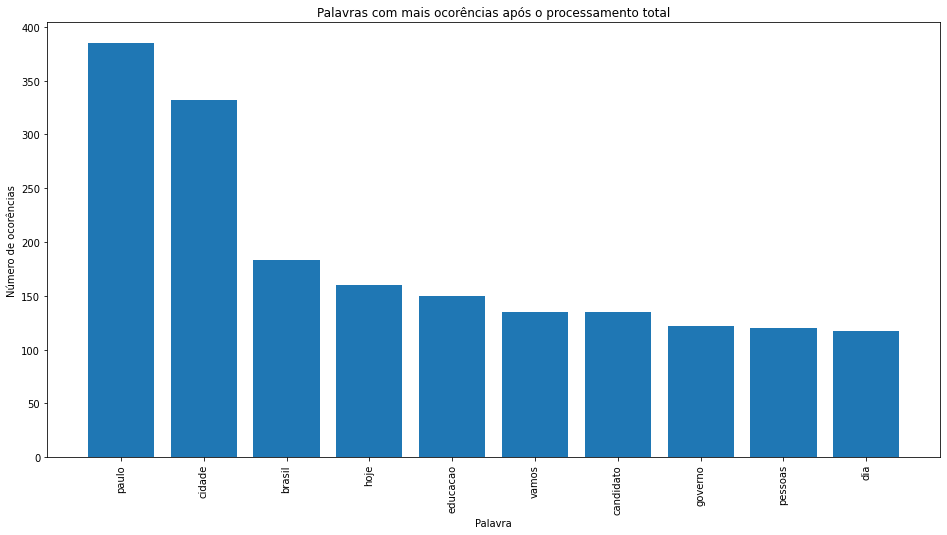

In [42]:
#=======================================================================
# visualização das top palavras
#=======================================================================

count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=10,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df_candidate['m_m_p_replaced_to_empty'])

for index in range(len(word_values)):
    print('{0} : {1}'.format(str(words[index]),str(word_values[index])))
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Palavras com mais ocorências após o processamento total');
ax.set_xlabel('Palavra');
ax.set_ylabel('Número de ocorências');
plt.show()
